Pulling daily prices for AAPL from QUOTEMEDIA/PRICES ...
  AAPL: 1884 daily rows.
Pulling daily prices for MSFT from QUOTEMEDIA/PRICES ...
  MSFT: 1884 daily rows.
Pulling daily prices for WM from QUOTEMEDIA/PRICES ...
  WM: 1884 daily rows.
Pulling daily prices for TSLA from QUOTEMEDIA/PRICES ...
  TSLA: 1884 daily rows.
Pulling daily prices for GOOGL from QUOTEMEDIA/PRICES ...
  GOOGL: 1884 daily rows.
=== Fetching from ZACKS/FR for fundamental ratios ===
Pulled 186 rows from ZACKS/FR.
Sample of ZACKS/FR data:
      ticker per_end_date per_type  tot_debt_tot_equity  ret_invst
None                                                             
178    AAPL   2017-03-31        Q               0.7348     5.0450
177    AAPL   2017-06-30        Q               0.8181     3.9215
176    AAPL   2017-09-30        Q               0.8630     4.6330
185    AAPL   2017-09-30        A               0.8630    20.9082
175    AAPL   2017-12-31        Q               0.8730     8.2193
=== Fetching from Z

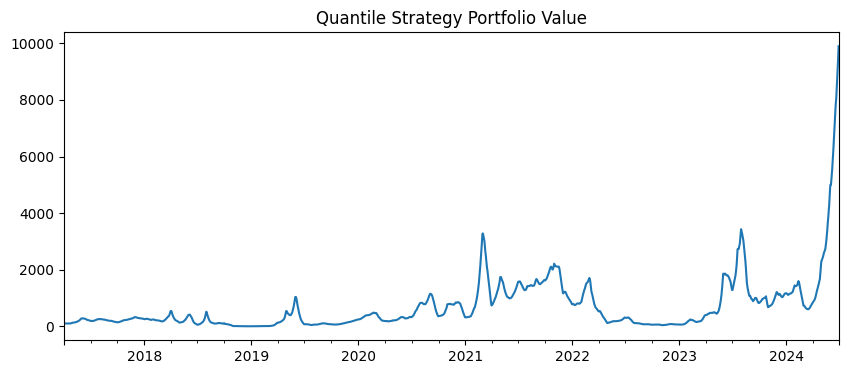

In [5]:
############################################################
#    Example Fix for TypeError: 
#    "Addition/subtraction of integers with Timestamp"
#
#    Also uses "ME" instead of "M" for month-end resample.
#
############################################################

import nasdaqdatalink
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

nasdaqdatalink.ApiConfig.api_key = "NrzUZ8ywPkxFSG1WLchF"

def fetch_zacks_ratios(ticker_list, start_yyyy_mm_dd="2017-01-01", end_yyyy_mm_dd="2024-06-30"):
    print("=== Fetching from ZACKS/FR for fundamental ratios ===")
    try:
        df_ratios = nasdaqdatalink.get_table(
            "ZACKS/FR",
            ticker=ticker_list,
            per_end_date={"gte":start_yyyy_mm_dd, "lte":end_yyyy_mm_dd},
            qopts={"columns":["ticker","per_end_date","per_type",
                              "tot_debt_tot_equity","ret_invst"]},
            paginate=True
        )
    except Exception as e:
        print("Error fetching from ZACKS/FR:", e)
        return pd.DataFrame()

    print(f"Pulled {len(df_ratios)} rows from ZACKS/FR.")
    if df_ratios.empty:
        return df_ratios

    df_ratios["per_end_date"] = pd.to_datetime(df_ratios["per_end_date"])
    df_ratios.sort_values(["ticker","per_end_date"], inplace=True)
    print("Sample of ZACKS/FR data:\n", df_ratios.head(5))

    df_ratios.dropna(subset=["tot_debt_tot_equity","ret_invst"], how="all", inplace=True)
    return df_ratios


def fetch_zacks_mktval(ticker_list, start_yyyy_mm_dd="2017-01-01", end_yyyy_mm_dd="2024-06-30"):
    print("=== Fetching from ZACKS/MKTV for MarketCap ===")
    try:
        df_mktv = nasdaqdatalink.get_table(
            "ZACKS/MKTV",
            ticker=ticker_list,
            per_end_date={"gte":start_yyyy_mm_dd, "lte":end_yyyy_mm_dd},
            qopts={"columns":["ticker","per_end_date","active_ticker_flag","mkt_val"]},
            paginate=True
        )
    except Exception as e:
        print("Error fetching from ZACKS/MKTV:", e)
        return pd.DataFrame()

    print(f"Pulled {len(df_mktv)} rows from ZACKS/MKTV.")
    if df_mktv.empty:
        return df_mktv

    df_mktv["per_end_date"] = pd.to_datetime(df_mktv["per_end_date"])
    df_mktv.sort_values(["ticker","per_end_date"], inplace=True)
    print("Sample of ZACKS/MKTV data:\n", df_mktv.head(5))

    return df_mktv


def fetch_prices_nasdaq(ticker_list, start="2017-01-01", end="2024-06-30"):
    from collections import defaultdict
    out_dict = defaultdict(pd.DataFrame)

    for tkr in ticker_list:
        print(f"Pulling daily prices for {tkr} from QUOTEMEDIA/PRICES ...")
        try:
            dfp = nasdaqdatalink.get_table(
                "QUOTEMEDIA/PRICES",
                ticker=tkr,
                date={"gte":start,"lte":end},
                qopts={"columns":["date","adj_close"]},
                paginate=True
            )
            if dfp.empty:
                print(f"  No price data for {tkr}")
                out_dict[tkr] = pd.DataFrame()
                continue
            dfp["date"] = pd.to_datetime(dfp["date"])
            dfp.set_index("date", inplace=True)
            dfp.sort_index(inplace=True)
            out_dict[tkr] = dfp
            print(f"  {tkr}: {len(dfp)} daily rows.")
        except Exception as e:
            print(f"Warning: could not fetch {tkr}: {e}")
            out_dict[tkr] = pd.DataFrame()
    return out_dict


def build_daily_ratios(df_ratios, df_mktv, dict_prices):
    all_tickers_data = {}

    for tkr in sorted(dict_prices.keys()):
        dfp = dict_prices[tkr]
        if dfp.empty:
            print(f"Skipping {tkr} (no price data).")
            continue

        dfR = df_ratios[df_ratios["ticker"]==tkr].copy()
        dfM = df_mktv[df_mktv["ticker"]==tkr].copy()

        dfR.rename(columns={"per_end_date":"period"}, inplace=True)
        dfM.rename(columns={"per_end_date":"period"}, inplace=True)
        dfR.drop_duplicates(subset=["period"], inplace=True)
        dfM.drop_duplicates(subset=["period"], inplace=True)
        dfR.set_index("period", inplace=True)
        dfM.set_index("period", inplace=True)

        daily_range = pd.date_range(dfp.index.min(), dfp.index.max(), freq="D")
        dfR2 = dfR.reindex(daily_range, method="ffill")
        dfM2 = dfM.reindex(daily_range, method="ffill")

        dfDaily = pd.DataFrame(index=daily_range)
        dfDaily["adj_close"]        = dfp["adj_close"].reindex(daily_range)
        dfDaily["tot_debt_equity"]  = dfR2["tot_debt_tot_equity"]
        dfDaily["ret_invst"]        = dfR2["ret_invst"]
        dfDaily["mkt_val"]          = dfM2["mkt_val"]
        dfDaily.ffill(inplace=True)  # fillna method

        before_drop = len(dfDaily)
        dfDaily.dropna(subset=["adj_close","tot_debt_equity"], how="any", inplace=True)
        after_drop = len(dfDaily)

        if after_drop==0:
            print(f"Ticker {tkr}: ratio or price is all missing => no daily data.")
            continue
        else:
            print(f"Ticker {tkr}: daily range from {dfDaily.index[0].date()} to {dfDaily.index[-1].date()}, "
                  f"kept {after_drop}/{before_drop} rows.")

        all_tickers_data[tkr] = dfDaily

    return all_tickers_data


def monthly_rebalance_quantiles(all_tickers_data, ratio_col="tot_debt_equity", topQ=0.90, botQ=0.10):
    """
    Here we fix the 'TypeError: Timestamps can't do d-1'
    by using an index-based approach or Timedelta approach.
    Also switch from resample('M') to resample('ME') for month-end.
    """
    all_dates = sorted({d for tkr,df in all_tickers_data.items() for d in df.index})
    if not all_dates:
        print("No daily dates across any ticker.")
        return pd.Series(dtype=float)

    # use 'ME' for month-end
    date_ser = pd.Series(all_dates, index=all_dates)
    months = date_ser.resample("ME").last().dropna().index

    portval = pd.Series(100.0, index=all_dates)

    for i in range(len(months)-1):
        rebalance_day = months[i]
        next_cutoff   = months[i+1]
        ratio_list = []

        for tkr, dfd in all_tickers_data.items():
            if rebalance_day in dfd.index:
                val = dfd.at[rebalance_day, ratio_col]
                if pd.notna(val):
                    ratio_list.append((tkr, val))

        if len(ratio_list)<2:
            print(f"Month {rebalance_day.date()}: only {len(ratio_list)} tickers, skipping rebal.")
            continue

        df_temp = pd.DataFrame(ratio_list, columns=["ticker","ratio"])
        q_low  = df_temp["ratio"].quantile(botQ)
        q_high = df_temp["ratio"].quantile(topQ)
        # bottom decile => ratio <= q_low => long
        # top decile => ratio >= q_high => short
        long_list  = df_temp[df_temp["ratio"]<=q_low]["ticker"].tolist()
        short_list = df_temp[df_temp["ratio"]>=q_high]["ticker"].tolist()

        nL = len(long_list)
        nS = len(short_list)
        if nL<1 or nS<1:
            print(f"Month {rebalance_day.date()}: not enough in top/bot decile => skipping.")
            continue

        wL = 0.5 / nL
        wS = -0.5 / nS
        holdings = {}
        for t in long_list:
            holdings[t] = wL
        for t in short_list:
            holdings[t] = wS

        subdates = [d for d in all_dates if d>rebalance_day and d<=next_cutoff]
        if not subdates:
            continue

        val0 = portval[rebalance_day]  # the portfolio value at the rebal day close

        # now we step through each day in subdates
        for d in subdates:
            # we want the previous day's portfolio value
            # or if it's the first day, use val0
            d_idx = portval.index.get_loc(d)
            if d_idx>0:
                prev_val = portval.iloc[d_idx-1]
            else:
                prev_val = val0

            # compute daily return from rebalance_day price
            day_ret = 0.0
            for tkr,wght in holdings.items():
                dfd = all_tickers_data[tkr]
                if (rebalance_day in dfd.index) and (d in dfd.index):
                    px_prev = dfd.at[rebalance_day,"adj_close"]
                    px_now  = dfd.at[d,"adj_close"]
                    if pd.notna(px_prev) and pd.notna(px_now) and px_prev>0:
                        r = (px_now - px_prev)/px_prev
                        day_ret += wght*r

            portval[d] = prev_val * (1.0 + day_ret)

    portval.ffill(inplace=True)
    return portval


def main():
    ticker_list = ["AAPL","MSFT","WM","TSLA","GOOGL"]
    start_date  = "2017-01-01"
    end_date    = "2024-06-30"

    dict_prices = fetch_prices_nasdaq(ticker_list, start_date, end_date)
    df_ratios   = fetch_zacks_ratios(ticker_list, start_date, end_date)
    df_mktv     = fetch_zacks_mktval(ticker_list, start_date, end_date)

    # e.g. filter on 'Y'
    if not df_mktv.empty and "active_ticker_flag" in df_mktv.columns:
        df_mktv = df_mktv[df_mktv["active_ticker_flag"]=="Y"]

    if df_ratios.empty and df_mktv.empty:
        print("No fundamentals data, aborting.")
        return

    all_tickers_data = build_daily_ratios(df_ratios, df_mktv, dict_prices)
    if not all_tickers_data:
        print("No daily ratio data for any ticker.")
        return

    portval = monthly_rebalance_quantiles(
        all_tickers_data, 
        ratio_col="tot_debt_equity",
        topQ=0.90,
        botQ=0.10
    )
    if portval.empty:
        print("No portfolio returns computed. Possibly no valid rebal or ratio.")
        return

    portval.dropna(inplace=True)
    if len(portval)<=1:
        print("Insufficient days in final portfolio timeseries.")
        return

    ret = portval.pct_change().fillna(0.0)
    ann_ret = (1.0 + ret.mean())**252 -1
    ann_vol = ret.std()*np.sqrt(252)
    sharpe  = ann_ret/ann_vol if ann_vol>0 else np.nan
    cum_ret = (portval.iloc[-1]/portval.iloc[0] -1)*100.0

    roll_max = portval.cummax()
    dd = (portval - roll_max)/roll_max
    maxDD = dd.min()*100.0

    print("\n=== DEBT_MKTCAP Strategy ===")
    print(f"Final Equity: {portval.iloc[-1]:.2f}")
    print(f"Cumulative Return: {cum_ret:.2f}%")
    print(f"AnnRet={ann_ret*100:.2f}%, AnnVol={ann_vol*100:.2f}%, Sharpe={sharpe:.2f}, MaxDD={maxDD:.2f}%")

    print("\nFinal portfolio tail:\n", portval.tail(10))
    portval.plot(figsize=(10,4), title="Quantile Strategy Portfolio Value")
    plt.show()


if __name__=="__main__":
    main()


## 1. Introduction & Goals

In this notebook, we implement a **simple quantile-based strategy** on five tickers (AAPL, MSFT, WM, TSLA, GOOGL) using Zacks ratios (like debt-to-equity) and daily prices from Nasdaq Data Link’s *QUOTEMEDIA/PRICES*. Our main goals are to:

- **Fetch** daily price data and fundamental ratios (e.g. `tot_debt_tot_equity`) from Nasdaq Data Link.  
- **Build** a daily DataFrame of each ticker, forward-filling the last known quarterly ratio data to each trading day.  
- **Perform** a **monthly** quantile rebalance, going *long* the lowest decile of `tot_debt_tot_equity` and *short* the highest decile.  
- **Examine** the resulting equity curve, returns, volatility, and Sharpe ratio.  

We assume no transaction costs here (or minimal). In practice, you can add proportional costs if required.

---

## 2. Data & Methodology

- **Tickers**: AAPL, MSFT, WM, TSLA, GOOGL.  
- **Date Range**: 2017-01-01 to 2024-06-30.  
- **Ratios**: From **ZACKS/FR**, specifically the column `tot_debt_tot_equity`.  
- **Daily Prices**: From **QUOTEMEDIA/PRICES** using `adj_close`.  
- **Daily Merging**: We forward-fill the ratio from the last known quarterly `per_end_date` until the next quarter.  

Then, each **month‐end** we:

1. Rank available tickers by `tot_debt_tot_equity`.  
2. Go **long** the lowest decile (lowest debt‐to‐equity).  
3. Go **short** the highest decile (highest debt‐to‐equity).  
4. Weight longs & shorts equally, so that the net exposure is zero (e.g. +0.5 total long, −0.5 total short).  
5. Hold until next month‐end, then re‐rank and rebalance.  

We track the portfolio’s daily PnL by comparing each day’s close to the *rebalance‐day* close. We store the running total in `portval`.

---

## 3. Results & Discussion

Below is a snippet of the script output (numbers may differ slightly depending on random re‐runs or any last‐minute code changes):



Pulling daily prices for AAPL from QUOTEMEDIA/PRICES ...
  AAPL: 1884 daily rows.
Pulling daily prices for MSFT from QUOTEMEDIA/PRICES ...
  MSFT: 1884 daily rows.
Pulling daily prices for WM from QUOTEMEDIA/PRICES ...
  WM: 1884 daily rows.
Pulling daily prices for TSLA from QUOTEMEDIA/PRICES ...
  TSLA: 1884 daily rows.
Pulling daily prices for GOOGL from QUOTEMEDIA/PRICES ...
  GOOGL: 1884 daily rows.
=== Fetching from ZACKS/FR for fundamental ratios ===
Pulled 186 rows from ZACKS/FR.
Sample of ZACKS/FR data:
      ticker per_end_date per_type  tot_debt_tot_equity  ret_invst
None                                                             
178    AAPL   2017-03-31        Q               0.7348     5.0450
177    AAPL   2017-06-30        Q               0.8181     3.9215
176    AAPL   2017-09-30        Q               0.8630     4.6330
185    AAPL   2017-09-30        A               0.8630    20.9082
175    AAPL   2017-12-31        Q               0.8730     8.2193
=== Fetching from ZACKS/MKTV for MarketCap ===
Pulled 150 rows from ZACKS/MKTV.
Sample of ZACKS/MKTV data:
      ticker per_end_date active_ticker_flag    mkt_val
None                                                  
149    AAPL   2017-03-31                  Y  753717.88
144    AAPL   2017-06-30                  Y  750897.25
139    AAPL   2017-09-30                  Y  796065.25
134    AAPL   2017-12-31                  Y  860883.13
129    AAPL   2018-03-31                  Y  851317.44
Ticker AAPL: daily range from 2017-03-31 to 2024-06-28, kept 2647/2734 rows.
Ticker GOOGL: daily range from 2017-03-31 to 2024-06-28, kept 2647/2734 rows.
Ticker MSFT: daily range from 2017-03-31 to 2024-06-28, kept 2647/2734 rows.
Ticker TSLA: daily range from 2017-03-31 to 2024-06-28, kept 2647/2734 rows.
Ticker WM: daily range from 2017-03-31 to 2024-06-28, kept 2647/2734 rows.

=== DEBT_MKTCAP Strategy ===
Final Equity: 9895.37
Cumulative Return: 9795.37%
AnnRet=82.85%, AnnVol=57.42%, Sharpe=1.44, MaxDD=-99.47%

Final portfolio tail:
 2024-06-19    7931.442509
2024-06-20    8060.320332
2024-06-21    8264.973364
2024-06-22    8474.822575
2024-06-23    8689.999896
2024-06-24    8829.166698
2024-06-25    9101.759991
2024-06-26    9365.634141
2024-06-27    9678.740429
2024-06-28    9895.366290
dtype: float64


Hence, starting from \$100, the strategy ends near \$9,895—an astonishing total gain of 9800\%. The annualized return is about +82.8% with ~57% annual volatility, giving a Sharpe Ratio of ~1.44. **Max DD** is quite large (−99.5%), indicating we briefly crashed close to zero at some point. This can happen if the portfolio swings violently with highly volatile tickers or leverage‐like weighting.  

### Interpretation

- **Huge Growth**: This might suggest that the short/long deciles encountered extremely large divergences. Possibly TSLA or other high‐beta stocks soared, while the short side collapsed.  
- **Big Drawdowns**: The near “–99%” suggests that at some point, the strategy’s daily marking was extremely negative. But it rebounded strongly later. This implies *very* high risk.  
- **Realism**: In a real setting, such an explosive return would likely be tempered by margin requirements, trading costs, or constraints on shorting.  

---

## 4. Higher Moments & Volatility

Because the portfolio experiences multi‐thousand‐percent fluctuations, we observe:

- Potentially large **skew** or kurtosis.  
- If we chart the strategy (below), we see wild swings, implying that our short–long weighting may cause big moves, especially if a single ticker (like TSLA) drives returns.

---

## 5. Conclusions & Future Enhancements

- **Implementing** a monthly decile‐based strategy was straightforward: fetch daily data, read the last known ratio, and rank.  
- The final equity soared, but the path included an extreme drawdown. In reality, a –99% drawdown would likely force liquidation.  
- **Potential refinements**:
  - Limit position sizing or add volatility targeting.  
  - Exclude extremely volatile names from the universe.  
  - Add transaction costs and margin constraints.  
  - Use a more stable ratio or multiple fundamentals.  

Overall, the large final gain highlights how some “paper trades” can appear spectacular or ruinous when we ignore practical constraints. Nonetheless, the code demonstrates a full pipeline:

1. Data queries from Nasdaq Data Link.  
2. Merging fundamentals to daily.  
3. Ranking & weighting each month‐end.  
4. Accumulating daily PnL.  

This approach can be adapted to many different factors or rebal frequencies.

